Importing the required libraries


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import aplpy
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
from astropy.stats import bootstrap
plt.rcParams.update({'font.size': 18})

Writing the required functions

In [10]:
def generate_RA_DEC_mesh(hdr):
    """generate_RA_DEC_mesh

    Generates the RA and DEC grid for the intensity map

    """
    if 'CDELT1' in hdr.header:
        RA_delt = hdr.header['CDELT1']
        DEC_delt = hdr.header['CDELT2']

    if 'CD1_1' in hdr.header:
        RA_delt = hdr.header['CD1_1']
        DEC_delt = hdr.header['CD2_2']

    RA_ref = (hdr.header['CRPIX1'])
    DEC_ref = (hdr.header['CRPIX2'])
    RA_ref_value = hdr.header['CRVAL1']
    DEC_ref_value = hdr.header['CRVAL2']
    RA_axis_len = hdr.header['NAXIS1']
    DEC_axis_len = hdr.header['NAXIS2']

    RA_axis = np.arange(1,RA_axis_len+1)
    DEC_axis = np.arange(1,DEC_axis_len+1)
    DEC_axis_modified = np.arange(1,RA_axis_len+1)
    
    DEC_array = (DEC_axis - DEC_axis_len/2)*DEC_delt + DEC_ref_value
    DEC_array_modified = (DEC_axis_modified - RA_axis_len/2)*DEC_delt + DEC_ref_value
    RA_array = RA_ref_value-(RA_axis - RA_axis_len/2)*(RA_delt*(-1)/np.cos(DEC_array_modified*0.01745))

    # #making a meshgrid from the arrays
    DEC_grid,RA_grid = np.meshgrid(DEC_array,RA_array , sparse=False, indexing='ij')
    return DEC_grid,RA_grid

def Calc_l(ra1,dec1,ra2,dec2):

    c1 = SkyCoord(ra1,dec1,unit = 'deg')
    c2 = SkyCoord(ra2,dec2,unit = 'deg')
    sep = c1.separation(c2)
    return sep.arcminute
    
def wrapper(Angle_grid):
    while ((np.nanmax(Angle_grid)>90) or (np.nanmin(Angle_grid)<-90)):
        Angle_selector =Angle_grid>90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] - 180
        Angle_selector = Angle_grid<-90
        Angle_grid[Angle_selector] = Angle_grid[Angle_selector] + 180
    return Angle_grid

Importing the data files

In [11]:
########## importing and testing the file

datafile_path1 = '..\data\DR21_CSO_processed2.csv'
datafile_path2 = '..\data\DR21_SCUPOL_processed2.csv'
datafile_path3 = '..\data\data_dr21.csv'

CSO_data = pd.read_csv(datafile_path1,delimiter=',',header=0)
SCUPOL_data = pd.read_csv(datafile_path2,delimiter=',',header=0)
OTF_data = pd.read_csv(datafile_path3,delimiter=',',header=0)
# print(OTF_data.shape)

tol = (OTF_data['RA'][1022] - OTF_data['RA'][1023])*2
print(tol)
def mapping_func(RA_array,DEC_array,x,y,f1,f2,tol):
    pfrac = np.ones_like(RA_array)*np.nan
    pol_ang = np.ones_like(RA_array)*np.nan
    for i in range(x.shape[0]):
        Selector = (abs(RA_array - x[i]) < tol/2) * (abs(DEC_array - y[i]) < tol/2)
        pfrac[Selector] = f1[i]
        pol_ang[Selector] = f2[i]
    return pfrac,pol_ang

CSO_pfrac,CSO_pol_ang = mapping_func(OTF_data['RA'],OTF_data['DEC'],CSO_data['RA_deg'],CSO_data['Dec_deg'],CSO_data['Po_%'],CSO_data['PolPA_deg'],tol = tol)
SCUPOL_pfrac,SCUPOL_pol_ang = mapping_func(OTF_data['RA'],OTF_data['DEC'],SCUPOL_data['RA'],SCUPOL_data['Dec'],SCUPOL_data['Po'],SCUPOL_data['PolPA'],tol = tol)


0.007094062493479214


In [15]:
# OTF_data['CSO_pfrac'] = CSO_pfrac
# OTF_data['CSO_pol_ang'] = CSO_pol_ang
# OTF_data['SCUPOL_prac'] = SCUPOL_pfrac
# OTF_data['SCUPOL_pol_ang'] = SCUPOL_pol_ang
# OTF_data.to_csv('..\data\DR21_data_OTF_CSO_SCUPOL.csv')

datafile_path4 = '..\data\DR21_data_OTF_CSO_SCUPOL.csv'
all_data = pd.read_csv(datafile_path4,delimiter=',',header=0)
all_data.head()

,Unnamed: 0,col1,RA,DEC,P,PolAng,I,S,ColumnDen,Temperature,8micron,CSO_pfrac,CSO_pol_ang,SCUPOL_prac,SCUPOL_pol_ang
0,0,377,309.747781,42.322611,2.099670,-16.388047,134.014050,25.388189,4.362466e+23,32.751101,116.312840,1.24,10.3,1.2,1.6
1,1,378,309.744234,42.322611,2.133796,-30.177101,83.413609,41.134980,3.275010e+23,32.858205,236.974066,1.62,1.8,1.2,1.6
2,2,379,309.740687,42.322611,2.683319,-35.027220,41.753709,47.564387,1.870289e+23,34.161906,126.865559,1.62,1.8,NaN,NaN
3,3,482,309.765510,42.325230,24.215572,3.287838,14.460258,4.713589,4.099721e+22,NaN,559.162018,2.08,13.0,2.3,0.7
4,4,483,309.761965,42.325230,15.045204,-1.189264,30.154074,8.958149,6.364249e+22,NaN,869.148089,1.95,21.4,2.1,4.0


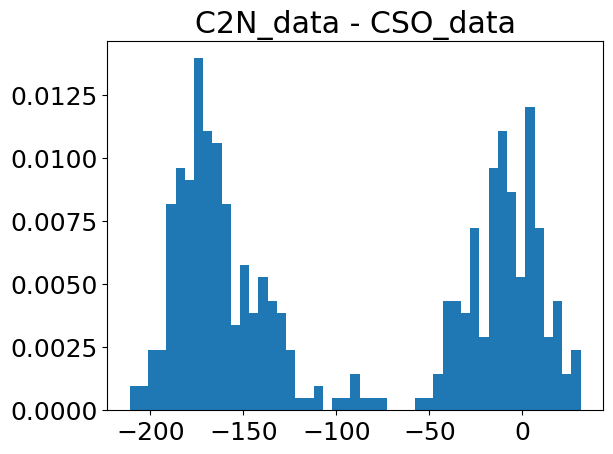

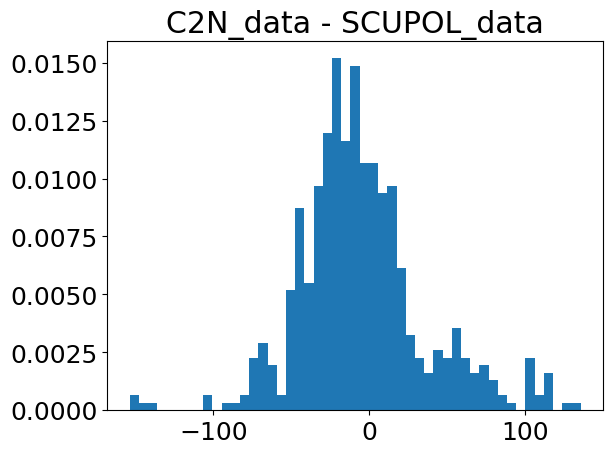

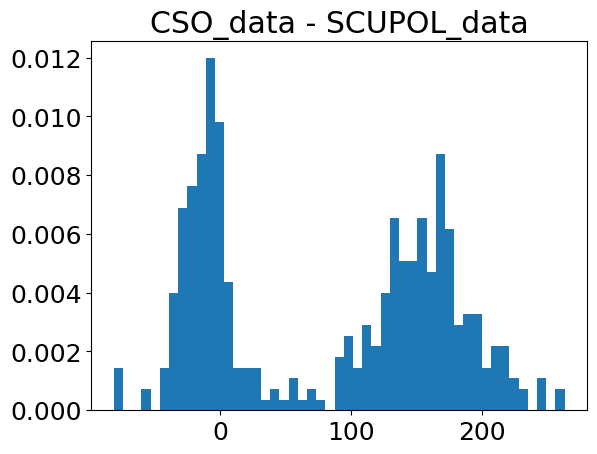

In [23]:
def hist_plot(array,delt):
    amax = np.nanmax(array)
    amin = np.nanmin(array)
    abin = np.linspace(amin,amax,delt)
    plt.figure()
    plt.hist(array,abin,density=True)

OTF_CSO_diff = all_data['PolAng'] - all_data['CSO_pol_ang']
OTF_SCUPOL_diff = all_data['PolAng'] - all_data['SCUPOL_pol_ang']
CSO_SCUPOL_diff = all_data['CSO_pol_ang'] - all_data['SCUPOL_pol_ang']

hist_plot(OTF_CSO_diff,50)
plt.title('OTF_data - CSO_data')
hist_plot(OTF_SCUPOL_diff,50)
plt.title('OTF_data - SCUPOL_data')
hist_plot(CSO_SCUPOL_diff,50)
plt.title('CSO_data - SCUPOL_data')
plt.show()

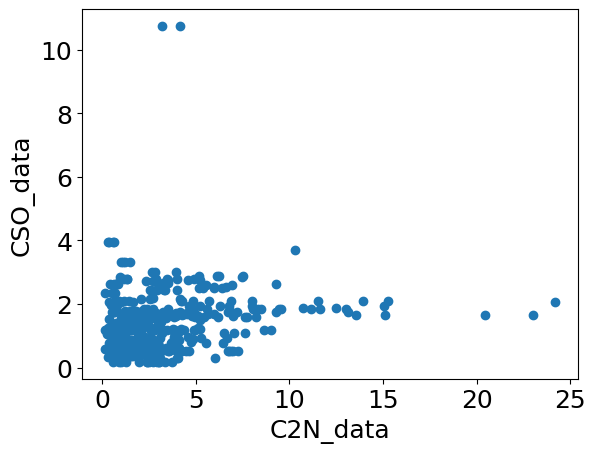

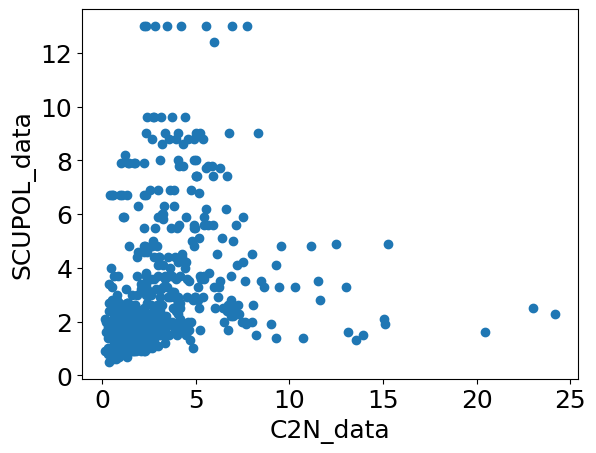

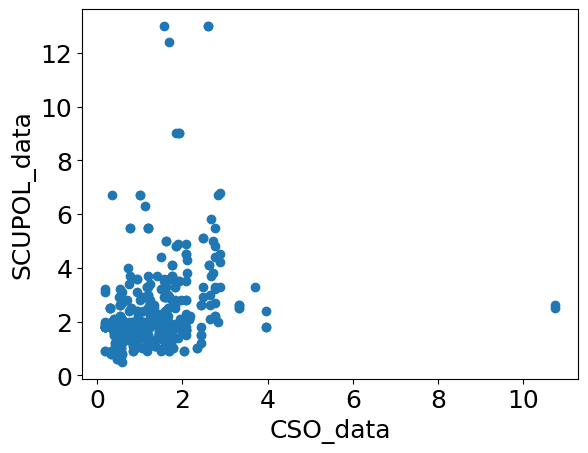

In [27]:
plt.figure()
plt.scatter(all_data['P'],all_data['CSO_pfrac'])
plt.xlabel('OTF_data')
plt.ylabel('CSO_data')
plt.figure()
plt.scatter(all_data['P'],all_data['SCUPOL_prac'])
plt.xlabel('OTF_data')
plt.ylabel('SCUPOL_data')
plt.figure()
plt.scatter(all_data['CSO_pfrac'],all_data['SCUPOL_prac'])
plt.xlabel('CSO_data')
plt.ylabel('SCUPOL_data')
plt.show()

